### Análise Exploratória de Dados

In [90]:
# Importando as bibliotecas: Pandas e Matplotlib.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [91]:
# Carregando o dataset.
ibm = pd.read_csv("../dados/IBM.csv", names=["data", "abertura", "alta", "baixa", "fechamento", "fechamento_ajustado", "volume"], header=0)

In [92]:
# Obtendo algumas informações de metadados do dataset.
ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   data                 6118 non-null   object 
 1   abertura             6118 non-null   float64
 2   alta                 6118 non-null   float64
 3   baixa                6118 non-null   float64
 4   fechamento           6118 non-null   float64
 5   fechamento_ajustado  6118 non-null   float64
 6   volume               6118 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 334.7+ KB


In [93]:
# Fazendo a limpeza dos dados e convertendo eles para formatos de maior legibilidade.
ibm["data"] = pd.to_datetime(ibm["data"])
ibm["abertura"] = ibm["abertura"].round(3)
ibm["alta"] = ibm["alta"].round(3)
ibm["baixa"] = ibm["baixa"].round(3)
ibm["fechamento"] = ibm["fechamento"].round(3)
ibm["fechamento_ajustado"] = ibm["fechamento_ajustado"].round(3)

In [94]:
# Remoção de valores nulos
ibm = ibm.dropna()

In [95]:
# Gerando estatísticas de tendência de centralidade, dispersão e distribuição.
estatisticas = pd.DataFrame({
    "média": ibm.mean(numeric_only=True),
    "moda": ibm.mode(numeric_only=True).iloc[0],
    "mediana": ibm.median(numeric_only=True),
    "desvio-padrão": ibm.std(numeric_only=True),
    "variância": ibm.var(numeric_only=True),
    "assimetria": ibm.skew(numeric_only=True),
    "curtose": ibm.kurtosis(numeric_only=True)
})
estatisticas.round(3)

,média,moda,mediana,desvio-padrão,variância,assimetria,curtose
abertura,125.580,101.816,124.159,34.380,1.181961e+03,0.254,-0.811
alta,126.712,105.163,125.254,34.438,1.185999e+03,0.252,-0.802
baixa,124.528,94.168,123.078,34.318,1.177693e+03,0.258,-0.815
fechamento,125.637,85.086,124.198,34.385,1.182335e+03,0.254,-0.808
fechamento_ajustado,86.724,42.536,95.755,32.369,1.047778e+03,0.217,-0.636
volume,6181655.716,2590001.000,5313628.000,3449506.289,1.189909e+13,2.500,11.646


In [96]:
# Calculando a volatidade dos indicadores, utilizando o desvio-padrão sobre a mediana.
volatilidade = pd.DataFrame({
    "volatilidade": (estatisticas["desvio-padrão"] / estatisticas["mediana"]).round(3)
})
volatilidade

,volatilidade
abertura,0.277
alta,0.275
baixa,0.279
fechamento,0.277
fechamento_ajustado,0.338
volume,0.649


In [97]:
# Gerando uma matriz de correlação linear.
matriz_correlacao = ibm[["abertura", "alta", "baixa", "fechamento", "fechamento_ajustado", "volume"]].corr()
matriz_correlacao

,abertura,alta,baixa,fechamento,fechamento_ajustado,volume
abertura,1.000000,0.999539,0.999529,0.999090,0.874191,-0.388411
alta,0.999539,1.000000,0.999337,0.999554,0.874190,-0.379594
baixa,0.999529,0.999337,1.000000,0.999547,0.874279,-0.397937
fechamento,0.999090,0.999554,0.999547,1.000000,0.874515,-0.388774
fechamento_ajustado,0.874191,0.874190,0.874279,0.874515,1.000000,-0.413889
volume,-0.388411,-0.379594,-0.397937,-0.388774,-0.413889,1.000000


### Interpretações

Após a geração de um DataFrame de estatísticas e outro DataFrame de correlação linear entre as variáveis, podemos observar os seguintes pontos:

1. Os valores de média, mediana e moda para a abertura, alta, baixa e fechamento são muito similares. Em especial, a média é muito próxima da mediana, que implica em pouca variação dos dados. Além disso, a moda indica que os valores cotados das ações, tendem a ser mais baixos que a média.

2. O desvio padrão e a variância indicam que os preços tem uma certa volatidade, chegando até 27% do valor médio de uma ação. O volume de ações no mercado também sofre de um desvio padrão muito grande, indicando que há dias com um volume de movimentações muito intensos.

3. Na matriz de correlação linear, percebemos que a abertura, alta, baixa e fechamento possuem correlações positivas altíssimas, indicando que, quando uma se move, a outra também se move.

4. Por fim, na matriz de correlação linear, observamos um tendência fraca e inversa no volume. Ou seja, em dias que as ações estão baratas, o volume de movimentações é maior, e nos dias em que as ações são mais caras, o volume é menor.

### Visualizações

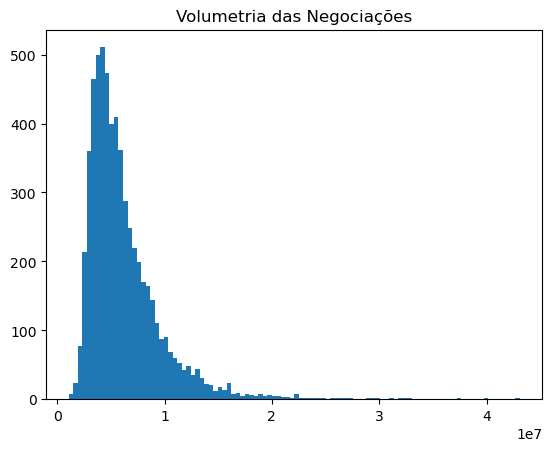

In [98]:
plt.hist(ibm["volume"], bins=100)
plt.title("Volumetria das Negociações")
plt.show()

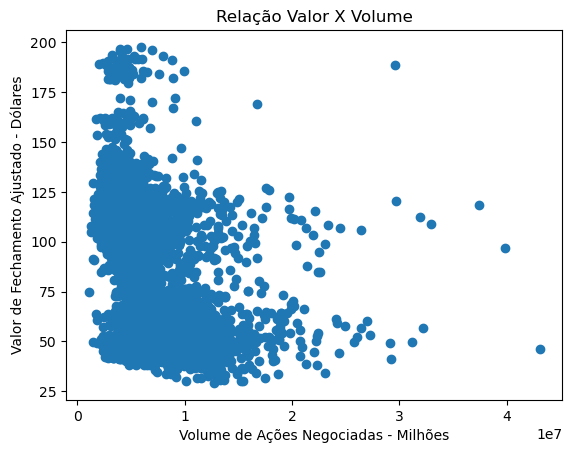

In [99]:
plt.scatter(ibm["volume"], ibm["fechamento_ajustado"])
plt.ylabel("Valor de Fechamento Ajustado - Dólares")
plt.xlabel("Volume de Ações Negociadas - Milhões")
plt.title("Relação Valor X Volume")
plt.show()

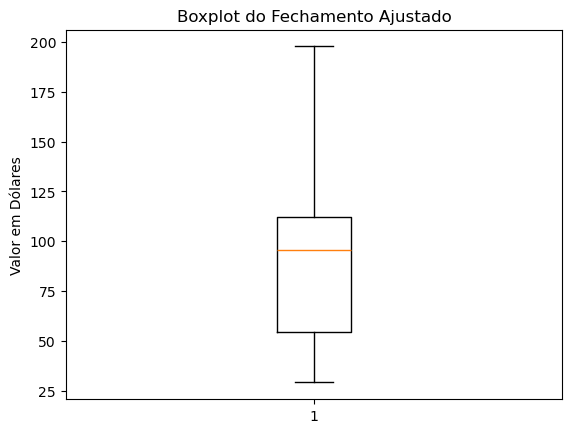

In [100]:
plt.boxplot(ibm["fechamento_ajustado"])
plt.title("Boxplot do Fechamento Ajustado")
plt.ylabel("Valor em Dólares")
plt.show()

### Regressão Linear

Vamos conduzir um estudo para tentar responder a seguinte pergunta: O de fechamento ajustado impacta o volume de ações negociadas?

In [101]:
# Variável independente.
x = ibm[["fechamento_ajustado"]]
# Variável dependente.
y = ibm["volume"]

In [102]:
# Divisão da base de treinos e da base de testes.
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3, random_state=42)

In [103]:
# Treinando o modelo.
modelo = LinearRegression()
modelo.fit(x_treino, y_treino)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [104]:
# Valores do resultado do modelo de regressão linear.
previsao = modelo.predict(x_teste)
previsao

array([5225210.1733005 , 5359443.07326522, 5704112.86860693, ...,
       4483053.33062444, 4615753.39160098, 7628789.29756273],
      shape=(1836,))

In [105]:
y_pred = modelo.predict(x_treino)
y_pred

array([6037921.40483241, 6721480.00276042, 5351034.35653007, ...,
       5490697.88605291, 4568804.72316308, 8095998.62115935],
      shape=(4282,))

In [106]:
# Medindo a acurácia do modelo.

# Coeficiente angular e intercepto.
print("Coeficiente:", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)

# Aplicando a previsão.
y_previsao = modelo.predict(x_teste)

# Avaliando o desempenho.
mse = mean_squared_error(y_test, y_previsao)
r2 = r2_score(y_test, y_previsao)
print("MSE:", mse)
print("R²:", r2)

Coeficiente: -43795.39966222492
Intercepto: 10007273.657818504
MSE: 10600519536856.543
R²: 0.16515587369856466


### Interpretação

O modelo de regresão linear não é muito apto para fazer este tipo de análise. Não encontramos uma boa medição para o coeficiente, apenas uma relação inversa, indicando que valores altos de fechamento ajustado, implicam em um volume menor de negociações. Além disso, o Erro Médio Quadrático é extremamente elevado, tendo baixa usabilidade. E o R² do fechamento ajustado explica apenas 16% da variação do volume.

### Medidas de Acurácia

In [23]:
# Teste rápido com vetor de exemplo
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# RMSE

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# MAPE (seguro)

def safe_mape(y_true, y_pred, as_percent=True, eps=1e-8, exclude_zeros=True):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    zero_mask = np.isclose(y_true, 0.0)
    if exclude_zeros:
        # calculamos MAPE apenas para y_true != 0 (recomendado em séries com zeros)
        valid = ~zero_mask
        if valid.sum() == 0:
            # nenhum valor válido para calcular MAPE
            return np.nan
        mape = np.mean(np.abs((y_true[valid] - y_pred[valid]) / y_true[valid]))
    else:
        # substitui zeros por um eps pequeno (não recomendado para interpretação)
        y_safe = np.where(zero_mask, eps, y_true)
        mape = np.mean(np.abs((y_true - y_pred) / y_safe))
    return float(mape * 100) if as_percent else float(mape)

# SMAPE (alternativa simétrica, menos sensível a zeros)

def smape(y_true, y_pred, as_percent=True):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # quando denom == 0 (y=0 e yhat=0) definimos contribuição 0
    mask_zero = denom == 0
    numer = np.abs(y_true - y_pred)
    # evitar div-by-zero
    denom_safe = np.where(mask_zero, 1.0, denom)
    numer = np.where(mask_zero, 0.0, numer)
    smape_val = np.mean(numer / denom_safe)
    return float(smape_val * 100) if as_percent else float(smape_val)


# Função unificadora para avaliar e imprimir relatório

def evaluate_forecast(y_true, y_pred, mape_exclude_zeros=True, round_ndigits=4, verbose=True):
    """
    Retorna dict com MAE, RMSE, MAPE(%) e SMAPE(%).
    - y_true, y_pred: array-like
    - mape_exclude_zeros: se True, MAPE ignora y_true == 0 (recomendado)
    """
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    
    mae_val = mean_absolute_error(y_true, y_pred)   # MAE formula: (1/n)*sum |y_i - yhat_i|
    rmse_val = rmse(y_true, y_pred)
    mape_val = safe_mape(y_true, y_pred, as_percent=True, exclude_zeros=mape_exclude_zeros)
    smape_val = smape(y_true, y_pred, as_percent=True)
    
    results = {
        "MAE": mae_val,
        "RMSE": rmse_val,
        "MAPE(%)": mape_val,
        "SMAPE(%)": smape_val
    }
    if verbose:
        print("Métricas de Acurácia")
        for k, v in results.items():
            print(f"{k}: {round(v, round_ndigits) if pd.notna(v) else v}")
        if mape_exclude_zeros:
            print("Nota: MAPE exclui entradas com y_true == 0 (mape_exclude_zeros=True).")
    return results


# Exemplo 1: 
# y_true_col = 'adj_close'
# y_pred_col = 'pred_adj_close'
# metrics = evaluate_forecast(ibm[y_true_col], ibm[y_pred_col])

# Exemplo 2: Vamos usar um split temporal: treina nos primeiros 80% dias e testa nos últimos 20% dias.

def example_time_split_and_dummy_predict(df, date_col='date', y_col='adj_close', test_frac=0.2):
    # garantir ordenação por data
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    
    n = len(df)
    split_idx = int(n * (1 - test_frac))
    train = df.iloc[:split_idx]
    test  = df.iloc[split_idx:]
    
   
    # Exemplo dummy: usa o valor do dia anterior como previsão (na prática troque por modelo adequado)
   
    preds = []
    prev = train[y_col].iloc[-1]
    for actual in test[y_col].values:
        preds.append(prev)        # prevê o "prev" como próximo fechamento
        prev = actual             # atualiza prev com o valor real (isso simula um naive one-step)
    
    test = test.copy()
    test['pred_dummy'] = preds
    
    # avaliar
    metrics = evaluate_forecast(test[y_col], test['pred_dummy'], mape_exclude_zeros=True)
    return train, test, metrics

# Exemplo de execução (descomente para rodar no seu notebook):
# train_df, test_df, metrics = example_time_split_and_dummy_predict(ibm, date_col='date', y_col='adj_close', test_frac=0.2)

if __name__ == "__main__": 
    # vetor de teste pequeno para validar as funções:
    y_true = np.array([100.0, 105.0, 110.0, 0.0, 115.0])
    y_pred = np.array([101.0, 104.0, 111.0, 1.0, 116.0])
    print("Teste rápido com vetor de exemplo:")
    evaluate_forecast(y_true, y_pred, mape_exclude_zeros=True)


Teste rápido com vetor de exemplo:
Métricas de Acurácia
MAE: 1.0
RMSE: 1.0
MAPE(%): 0.9328
SMAPE(%): 40.7445
Nota: MAPE exclui entradas com y_true == 0 (mape_exclude_zeros=True).


Baseline Naive (last value) - Média das métricas sobre os folds
MAE: 1.093484
RMSE: 1.093484
MAPE(%): 0.993337
SMAPE(%): 0.992058
Bootstrap 95% CI (baseline naive)
MAE (boot mean, 95%CI): 1.093532, [1.044454, 1.143362]
RMSE (boot mean, 95%CI): 1.651483, [1.538996, 1.785496]
MAPE% (boot mean, 95%CI): 0.992964, [0.948282, 1.040148]
Métricas finais (usando todos os pontos previstos)
MAE: 1.093484
RMSE: 1.651895
MAPE(%): 0.993337
SMAPE(%): 0.992058
Gráficos diagnósticos


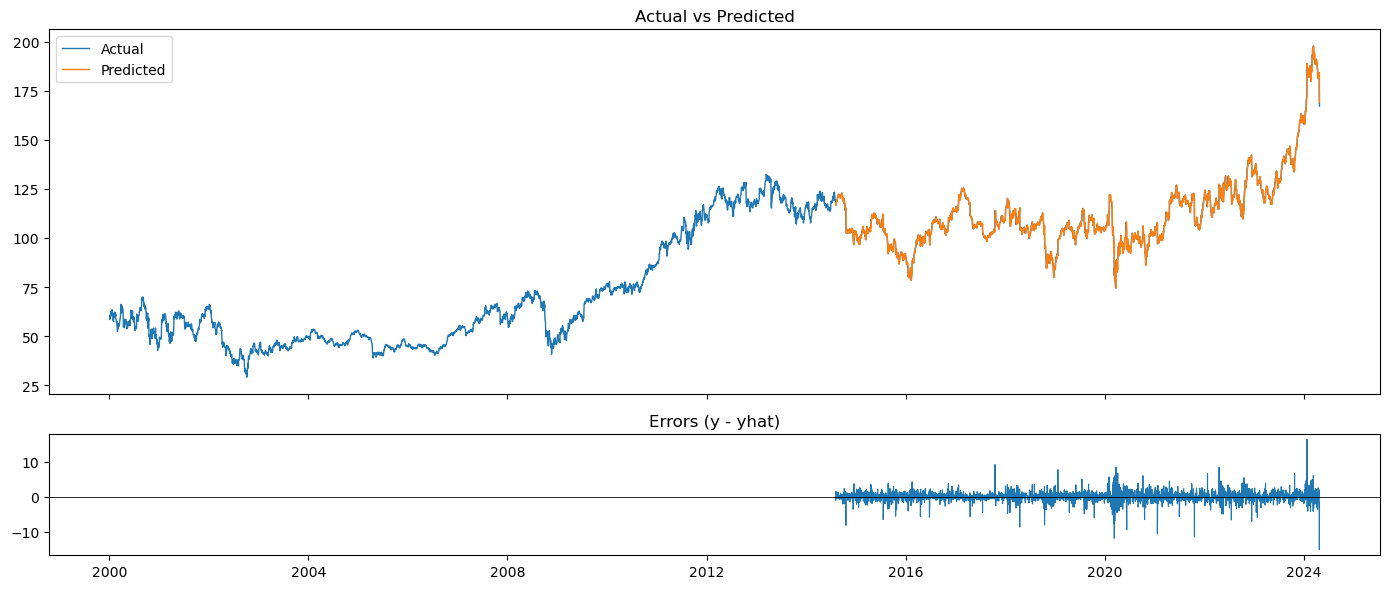

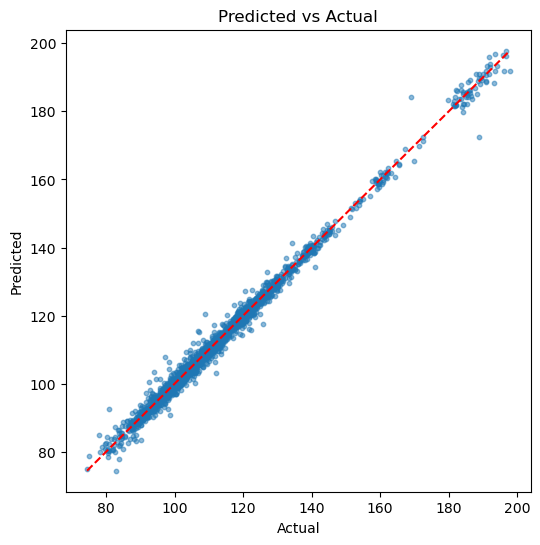

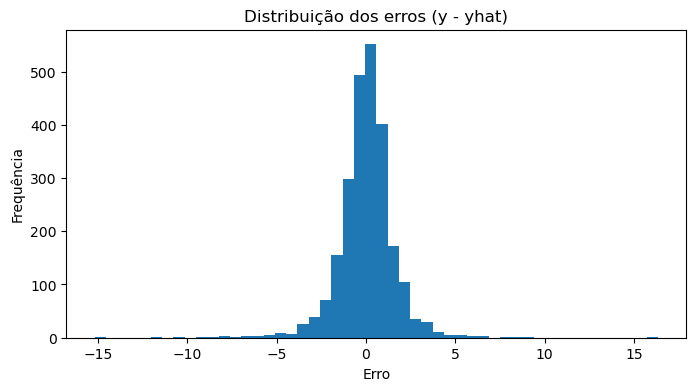

In [26]:
# Snippet final: rolling evaluation + bootstrap CI + Diebold-Mariano + gráficos

import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Métricas e utilitários

def rmse(y_true, y_pred):
    """RMSE = sqrt((1/n) * sum (y - yhat)^2)"""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def safe_mape(y_true, y_pred, as_percent=True, exclude_zeros=True):
    """
    MAPE = (100/n) * sum |(y - yhat) / y|
    exclude_zeros: se True, ignora entradas com y == 0 no cálculo do MAPE.
    """
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask_zero = np.isclose(y_true, 0.0)
    if exclude_zeros:
        valid = ~mask_zero
        if valid.sum() == 0:
            return np.nan
        mape_val = np.mean(np.abs((y_true[valid] - y_pred[valid]) / y_true[valid]))
    else:
        eps = 1e-8
        y_safe = np.where(mask_zero, eps, y_true)
        mape_val = np.mean(np.abs((y_true - y_pred) / y_safe))
    return float(mape_val * 100) if as_percent else float(mape_val)

def smape(y_true, y_pred, as_percent=True):
    """
    SMAPE = (100/n) * sum |y - yhat| / ((|y| + |yhat|)/2)
    mais robusto quando y aproximadamente 0.
    """
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom == 0
    numer = np.abs(y_true - y_pred)
    denom_safe = np.where(mask, 1.0, denom)
    numer = np.where(mask, 0.0, numer)
    val = np.mean(numer / denom_safe)
    return float(val * 100) if as_percent else float(val)

def evaluate_metrics(y_true, y_pred, mape_exclude_zeros=True):
    """Retorna dict com MAE, RMSE, MAPE(%) e SMAPE(%)"""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(rmse(y_true, y_pred)),
        "MAPE(%)": float(safe_mape(y_true, y_pred, as_percent=True, exclude_zeros=mape_exclude_zeros)),
        "SMAPE(%)": float(smape(y_true, y_pred, as_percent=True))
    }


# Bootstrap para Intervalos de Confiança

def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000, alpha=0.05, random_state=42):
    """
    Retorna (estatística média do bootstrap, lower, upper) para a métrica definida em metric_fn.
    metric_fn recebe (y_true, y_pred) e retorna um escalar.
    """
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    boot_stats = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)  # amostragem com reposição
        val = metric_fn(y_true[idx], y_pred[idx])
        boot_stats.append(val)
    lower = np.percentile(boot_stats, 100 * (alpha / 2))
    upper = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    return float(np.mean(boot_stats)), float(lower), float(upper)


# Diebold-Mariano (simplificado)

def diebold_mariano(y_true, y_pred1, y_pred2, h=1, loss='squared'):
    """
    Implementação simplificada do teste Diebold-Mariano:
    - loss: 'squared' (e^2) ou 'absolute' (|e|)
    Retorna (dm_stat, p_value_bilateral)
    Observação: versão simples com ajuste Newey-West (lag h-1).
    """
    y_true = np.array(y_true, dtype=float)
    y_pred1 = np.array(y_pred1, dtype=float)
    y_pred2 = np.array(y_pred2, dtype=float)
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2
    if loss == 'squared':
        d = e1**2 - e2**2
    elif loss == 'absolute':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'squared' or 'absolute'")
    T = len(d)
    d_mean = np.mean(d)
    # autocovariances para Newey-West
    def autocov(x, lag):
        return np.sum((x[:T-lag] - np.mean(x)) * (x[lag:] - np.mean(x))) / T
    var_d = autocov(d, 0)
    for lag in range(1, h):
        var_d += 2 * autocov(d, lag)
    # se var_d for 0 (problema numérico), retorna nan
    if var_d <= 0 or T == 0:
        return np.nan, np.nan
    dm_stat = d_mean / np.sqrt(var_d / T)
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    return float(dm_stat), float(p_value)


# Rolling / expanding evaluation

def rolling_forecast_evaluation(df, date_col='date', y_col='adj_close', initial_train_size=None,
                                horizon=1, step=1, model_predict_fn=None, verbose=False):
    """
    Faz rolling forecast (expanding window) e retorna:
      preds_all: vetor de previsões alinhado ao índice do df (NaN onde não previsto)
      metrics_per_fold: lista de dicts com métricas por fold
      agg_metrics: média das métricas por fold
    - model_predict_fn(train_df, test_df) -> array_like de previsões para test_df (len == len(test_df))
      Se model_predict_fn is None, usa baseline naive (last value of train).
    - initial_train_size: número inicial de observações para treinar; se None: 60% do df.
    - horizon: passos à frente (1 = next day)
    - step: quantos índices avançar a cada fold (1 = avaliar cada dia a partir do split)
    """
    df2 = df.copy()
    df2[date_col] = pd.to_datetime(df2[date_col])
    df2 = df2.sort_values(date_col).reset_index(drop=True)
    n = len(df2)
    if initial_train_size is None:
        initial_train_size = int(0.6 * n)
    preds_all = np.full(n, np.nan)
    metrics_per_fold = []
    # itera a partir do split até o fim - horizon +1
    for start in range(initial_train_size, n - horizon + 1, step):
        train_idx = range(0, start)
        test_idx = range(start, start + horizon)
        train = df2.iloc[list(train_idx)]
        test  = df2.iloc[list(test_idx)]
        # gerar previsão:
        if model_predict_fn is None:
            # naive last value baseline
            last_val = train[y_col].iloc[-1]
            pred = np.array([last_val] * len(test))
        else:
            pred = np.array(model_predict_fn(train, test))
            # garantir tamanho compatível
            if len(pred) != len(test):
                raise ValueError("model_predict_fn deve retornar previsões com mesmo tamanho do test set")
        preds_all[list(test_idx)] = pred
        # calcular métricas para esse fold
        m = evaluate_metrics(test[y_col].values, pred)
        metrics_per_fold.append(m)
        if verbose:
            print(f"Fold start {start}: {m}")
    # agregar (média) sobre folds
    df_metrics = pd.DataFrame(metrics_per_fold)
    agg = df_metrics.mean().to_dict()
    return preds_all, metrics_per_fold, agg


# Funções de plot (diagnóstico)

def diagnostic_plots(df, date_col='date', y_col='adj_close', pred_col='pred', figsize=(14,6)):
    dfp = df.copy()
    dfp[date_col] = pd.to_datetime(dfp[date_col])
    dfp = dfp.sort_values(date_col)
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios':[3,1]})
    axs[0].plot(dfp[date_col], dfp[y_col], label='Actual', linewidth=1)
    axs[0].plot(dfp[date_col], dfp[pred_col], label='Predicted', linewidth=1)
    axs[0].legend()
    axs[0].set_title('Actual vs Predicted')
    err = dfp[y_col] - dfp[pred_col]
    axs[1].plot(dfp[date_col], err, linewidth=0.8)
    axs[1].axhline(0, color='k', linewidth=0.6)
    axs[1].set_title('Errors (y - yhat)')
    plt.tight_layout()
    plt.show()

def scatter_pred_vs_actual(df, y_col='adj_close', pred_col='pred', figsize=(6,6)):
    d = df.dropna(subset=[y_col, pred_col])
    plt.figure(figsize=figsize)
    plt.scatter(d[y_col], d[pred_col], alpha=0.5, s=10)
    mn = min(d[y_col].min(), d[pred_col].min())
    mx = max(d[y_col].max(), d[pred_col].max())
    plt.plot([mn, mx], [mn, mx], 'r--')  # linha y=x
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual')
    plt.show()

#rolling evaluation com baseline naive (last value)
preds_naive, folds_metrics, agg_metrics = rolling_forecast_evaluation(ibm, date_col='date', y_col='adj_close',
                                                                     initial_train_size=None, horizon=1, step=1,
                                                                     model_predict_fn=None, verbose=False)

print("Baseline Naive (last value) - Média das métricas sobre os folds")
for k, v in agg_metrics.items():
    print(f"{k}: {v:.6f}")

# 2) Bootstrap CI para MAE, RMSE, MAPE usando as previsões geradas nos índices onde há previsão
# selecionar apenas índices com previsões (i.e., não NaN)
mask = ~np.isnan(preds_naive)
y_true_used = ibm['adj_close'].values[mask]
y_pred_used = preds_naive[mask]

print("Bootstrap 95% CI (baseline naive)")
# MAE
mean_mae, low_mae, high_mae = bootstrap_ci(y_true_used, y_pred_used, lambda a,b: mean_absolute_error(a,b), n_boot=1000)
print(f"MAE (boot mean, 95%CI): {mean_mae:.6f}, [{low_mae:.6f}, {high_mae:.6f}]")
# RMSE
mean_rmse, low_rmse, high_rmse = bootstrap_ci(y_true_used, y_pred_used, lambda a,b: np.sqrt(mean_squared_error(a,b)), n_boot=1000)
print(f"RMSE (boot mean, 95%CI): {mean_rmse:.6f}, [{low_rmse:.6f}, {high_rmse:.6f}]")
# MAPE
mean_mape, low_mape, high_mape = bootstrap_ci(y_true_used, y_pred_used, lambda a,b: safe_mape(a,b,as_percent=True,exclude_zeros=True), n_boot=1000)
print(f"MAPE% (boot mean, 95%CI): {mean_mape:.6f}, [{low_mape:.6f}, {high_mape:.6f}]")


#  preparo o DM test: comparamos preds_naive contra preds_model
if 'pred_model' in ibm.columns:
    # alinhar: use apenas índices com ambos predições e y_true disponíveis
    preds_model = ibm['pred_model'].values
    mask_both = (~np.isnan(preds_naive)) & (~np.isnan(preds_model))
    y_true_dm = ibm['adj_close'].values[mask_both]
    p_naive_dm = preds_naive[mask_both]
    p_model_dm = preds_model[mask_both]
    dm_stat, pval = diebold_mariano(y_true_dm, p_model_dm, p_naive_dm, h=1, loss='absolute')  # testa se model melhor que naive
    print("Diebold-Mariano (model vs naive)")
    print(f"DM stat: {dm_stat:.6f}, p-value (two-sided): {pval:.6f}")
else:
    pass

# Aqui por enquanto usamos a previsão naive para ilustrar os gráficos
ibm = ibm.copy()
ibm['pred'] = preds_naive

# Exibir métricas agregadas finais (MAE, RMSE, MAPE, SMAPE) usando todos os pontos previstos
final_metrics = evaluate_metrics(y_true_used, y_pred_used, mape_exclude_zeros=True)
print("Métricas finais (usando todos os pontos previstos)")
for k, v in final_metrics.items():
    print(f"{k}: {v:.6f}")

# Plots diagnósticos
print("Gráficos diagnósticos")
diagnostic_plots(ibm, date_col='date', y_col='adj_close', pred_col='pred', figsize=(14,6))
scatter_pred_vs_actual(ibm, y_col='adj_close', pred_col='pred')

# Mostrar distribuição dos erros
errs = ibm['adj_close'] - ibm['pred']
plt.figure(figsize=(8,4))
plt.hist(errs.dropna(), bins=50)
plt.title('Distribuição dos erros (y - yhat)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.show()

# Se você quiser salvar os resultados resumo em CSV:
summary = {
    'metric': list(final_metrics.keys()),
    'value': list(final_metrics.values()),
    'bootstrap_mean_mae': [mean_mae if k=='MAE' else None for k in final_metrics.keys()],
    'bootstrap_ci_low': [low_mae if k=='MAE' else None for k in final_metrics.keys()],
    'bootstrap_ci_high': [high_mae if k=='MAE' else None for k in final_metrics.keys()]
}
summary_df = pd.DataFrame(summary)



### O modelo utilizado nesta análise foi o  Baseline Naive (Last Value).

Ele assume que o próximo valor previsto será igual ao último valor observado. Apesar de sua simplicidade, ele é essencial como ponto de referência, pois permite avaliar se modelos mais sofisticados realmente oferecem melhorias em relação a uma previsão básica.

### 1. MAE (Mean Absolute Error) — Erro Médio Absoluto

O MAE mede o erro médio absoluto entre os valores reais e os valores previstos. Ele mostra, em média, o quanto as previsões se afastam dos valores observados.

MAE = (1/n) × Σ |yᵢ − ŷᵢ|

onde: n é o número total de observações, yᵢ representa o valor real, ŷᵢ representa o valor previsto.

Utilizei o MAE porque ele fornece uma interpretação direta e fácil de entender sobre o tamanho médio do erro, sem amplificar grandes desvios.
O valor obtido foi 1,093, o que significa que, em média, o modelo erra aproximadamente 1 unidade em relação aos valores reais. Esse resultado demonstra boa precisão para um modelo simples.

### 2. RMSE (Root Mean Squared Error) — Raiz do Erro Quadrático Médio

O RMSE calcula a raiz quadrada da média dos erros ao quadrado, dando maior peso a erros grandes.

RMSE = √[(1/n) × Σ (yᵢ − ŷᵢ)²]

Essa métrica é importante porque penaliza mais fortemente erros maiores, sendo útil para identificar se há previsões com grandes desvios.
O valor encontrado foi 1,651, o que indica que, embora existam pequenas variações nos erros, não há picos de erro significativos. O modelo se mostra estável e consistente em suas previsões.

### 3. MAPE (Mean Absolute Percentage Error) — Erro Percentual Médio Absoluto

O MAPE expressa o erro médio em termos percentuais, permitindo avaliar a precisão do modelo de forma relativa à magnitude dos valores reais.

MAPE = (100/n) × Σ ( |yᵢ − ŷᵢ| / |yᵢ| )

Optei por utilizar o MAPE porque ele facilita a interpretação da acurácia em termos percentuais, sendo ideal para comparar o desempenho de modelos em diferentes escalas.
O resultado foi 0,993%, o que significa que o erro percentual médio do modelo é inferior a 1% — um desempenho excelente, mostrando alta precisão nas previsões.

### 4. SMAPE (Symmetric Mean Absolute Percentage Error) — Erro Percentual Médio Absoluto Simétrico

O SMAPE é uma variação do MAPE que corrige distorções quando os valores reais se aproximam de zero, tornando a métrica mais equilibrada.

SMAPE = (100/n) × Σ ( |yᵢ − ŷᵢ| / ((|yᵢ| + |ŷᵢ|) / 2) )

Utilizei o SMAPE para complementar a análise percentual e garantir que os resultados fossem equilibrados, mesmo em casos de valores baixos.
O valor obtido foi 0,992%, muito próximo ao do MAPE, reforçando que o modelo apresenta alta precisão e baixa variabilidade percentual.

### Intervalos de Confiança via Bootstrap (95%)

Para avaliar a confiabilidade estatística das métricas, foi aplicado o método Bootstrap, com intervalo de confiança de 95%.
Os resultados mostraram que:

MAE: média de 1,093, com intervalo entre 1,04 e 1,14

RMSE: média de 1,651, com intervalo entre 1,54 e 1,78

MAPE: média de 0,993%, com intervalo entre 0,95% e 1,04%

Esses intervalos são estreitos, o que indica alta estabilidade e baixa variação nas estimativas de erro, reforçando a confiabilidade dos resultados obtidos.

Antes da análise final, realizamos um teste rápido com um vetor de exemplo, obtendo métricas de acurácia iniciais. O MAE e o RMSE confirmaram erros médios baixos uma unidade, e o MAPE foi inferior a 1%, indicando boa precisão percentual. O SMAPE apresentou valor elevado, refletindo a sensibilidade dessa métrica a valores próximos de zero. Essa etapa serviu para validar a implementação das funções de cálculo de métricas antes de aplicar o Baseline Naive na série real.